# Online Social Platform - SPARSE numerical solution

## authors: A. Giovanidis, B. Baynat, C. Magnien, A. Vendeville

08 mai 2020

### Code related to the submission: "Ranking Online Social Users by their Influence"

We present again the general problem to be solved numerically, and specify here that this is a solution that profits from sparsity. The algorithm can be applyied to data traces with sizes of millions of users. 

We analyse the influence of users in a generic online social platform. 

In such platform, there are $N$ users in total. Each user $n$ is considered as a virtual node and has a Newsfeed and a Wall. Suppose the Newsfeed of size $M$ and the Wall of size $K$. Furthermore, each user has a set of leaders, $L^{(n)}$, and he/she can be the leader of others. The Newsfeed of $n$ is refreshed instantaneously with posts published on the Walls of his Leaders. The user visits his Newsfeed and chooses among the currently available posts to re-post on his own Wall with rate $\mu^{(n)}\geq 0$ [posts/unit-time]. Additionally, he produces own posts on his Wall with rate $\lambda^{(n)}\geq 0$. These posts are marked on their production by the user-author index $(n)$.

**Assumptions:** The choice of which post to share on one's Wall and which post to evict when a new post arrives is uniformly random, among the present posts on the Wall and the Newsfeed. Also, both post-feed processes per user are assumed Poisson.

Consider a particular user $i$. The steady-state probability to find posts from user $i$ on the Newsfeed and Wall of user $n$ is the tuple $(p_i^{(n)},q_i^{(n)})$. With this, we form the steady state column-vectors

$Pvec(i):=(Pvec(1,i),\ldots,Pvec(N,i))=(p_i^{(1)},\ldots,p_i^{(n)})$, and

$Qvec(i):=(Qvec(1,i),\ldots,Qvec(N,i))=(q_i^{(1)},\ldots,q_i^{(n)})$.

These are the steady-state vectors for posts of origin $(i)$ on all the Newsfeeds and Walls of users. 

### Linear System solution

To find the values of the steady-state vectors $Pvec(i)$ and Qvec(i), one needs to solve the following linear system:

    (1) Pvec(i) = A.Pvec(i) + b(i)

    (2) Qvec(i) = C.Pvec(i) + d(i).

In the above $A$, $C$ are $N\times N$ matrices and $b(i)$, $d(i)$ are $N\times 1$ column vectors.

$A(j,k) = \frac{\mu^{(k)}}{\sum_{\ell\in L^{(j)}}\lambda^{(\ell)}+\mu^{(\ell)}}\mathbf{1}(k\in L^{(j)})$,

$b(j,i) = \frac{\lambda^{(i)}}{\sum_{\ell\in L^{(j)}}\lambda^{(\ell)}+\mu^{(\ell)}}\mathbf{1}(i\in L^{(j)})$,

$C(j,i) = \frac{\mu^{(j)}}{\lambda^{(j)}+\mu^{(j)}}\mathbf{1}(j==i)$,

$d(j,i) = \frac{\lambda^{(i)}}{\lambda^{(i)}+\mu^{(i)}}\mathbf{1}(j==i)$.

### Iterative method

In our program here, we will make extensive use of dictionaries (hash-tables), where we store only the non-negative elements of matrices and vectors. For the solution, we apply the iterative method

    (1*) Pvec(i,t+1) = A.Pvec(i,t) + b(i)

and after its convergence to the solution Pvec(i) = Pvec(i,inf) we can calculate

    (2*) Qvec(i) = C.Pvec(i) + d(i)
    
The matrix-vector multiplication is done also in a sparse way, that guarantees that only lines that contribute to the update are chosen, among the possible $N$. We do so to reduce the computational effort per iteration and avoid tedious multiplications by zero. It can be well understood that such an approach can considerably reduce implementation time for sparse matrices of large size N.

# Implementation

In [1]:
%pylab inline
import math
import numpy as np
import networkx as nx
from IPython.core.debugger import Tracer

Populating the interactive namespace from numpy and matplotlib


### 1. TEST Input Graph: Grid

First we create a small test example from a Grid graph, to verify at the end that the sparse algorithm works correctly (for small sizes of inputs). We can then apply the sparse algorithm to very large graphs from real traces.

In [2]:
#Grid size (number of nodes) test example
NS = 9

In the Grid graph, every node has 4 leaders, except the nodes on the 4 vertices of the Grid who have 2 leaders and the nodes on the edges who have 3.

The size of the grid graph should be such that $\sqrt{N}$ is a postive integer.

In [3]:
def grid_graph(N):
    #
    dim1 = math.sqrt(N)
    #
    # Check validity of Grid size
    if np.abs(dim1-int(dim1))>0:
        return print("not valid graph size N\n")
    #
    dim1 = int(dim1)
    #
    # If size is correct, then produce a list of Leaders.
    # Nodes are indexed from top-left ("0") to bottom-right ("N-1")
    # and in each row the indexing increased from left to right.
    #
    Lead = [list() for j in range(N)]
    #
    # Internal nodes with 4 leaders each.
    for n in range(1,dim1-1):
        for m in range(1,dim1-1):
            indx = dim1*n+m
            Lead[indx].extend([dim1*(n+1)+m, dim1*(n-1)+m, dim1*n+m+1, dim1*n+m-1 ])
    # Four vertices with 2 leaders each.
    Lead[0].extend([1, dim1])
    Lead[dim1-1].extend([dim1-2,dim1*2-1])
    Lead[dim1*(dim1-1)].extend([dim1*(dim1-1)+1,dim1*(dim1-2)])
    Lead[N-1].extend([N-2,dim1*(dim1-1)-1])
    # Remaining nodes on the four edges, not vertices.
    # Top
    for m in range(1,dim1-1):
        Lead[m].extend([m-1,m+1,dim1+m])
    # Bottom
    for m in range(1,dim1-1):
        Lead[dim1*(dim1-1)+m].extend([dim1*(dim1-1)+m-1,dim1*(dim1-1)+m+1,dim1*(dim1-2)+m])
    # Left
    for n in range(1,dim1-1):
        Lead[dim1*n].extend([dim1*n+1,dim1*(n-1),dim1*(n+1)])
    # Right
    for n in range(1,dim1-1):
        Lead[dim1*(n+1)-1].extend([dim1*(n+1)-2,dim1*(n)-1,dim1*(n+2)-1])

    return Lead

In [4]:
LeadGridS = grid_graph(NS)
print(LeadGridS)

[[1, 3], [0, 2, 4], [1, 5], [4, 0, 6], [7, 1, 5, 3], [4, 2, 8], [7, 3], [6, 8, 4], [7, 5]]


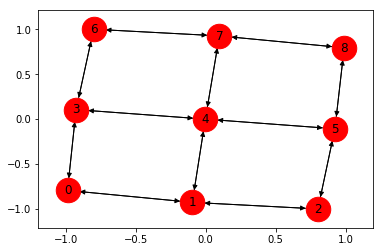

In [5]:
Ggrid=nx.DiGraph()
for n in range(NS):
    ln = list()
    ln = LeadGridS[n]
    for j in range(len(ln)):
        Ggrid.add_edge(ln[j],n)

pos=nx.spring_layout(Ggrid,iterations=100)
nx.draw_networkx(Ggrid,pos,arrows=True,with_labels=True,node_size=600,node_color='r')

TEST Input parameters of the model (lambda and mu vectors) for different scenaria.

In [6]:
lam = 1.
mu = 1
Lvec2 = lam*np.ones(NS, np.float64)
Mvec2 = mu*np.ones(NS, np.float64)
lam1 = 10
mu1 = 0.5
Lvec3 = list(Lvec2)
Mvec3 = list(Mvec2)
Lvec3[0] = lam1
Mvec3[0] = mu1
Lvec3 = np.asarray(Lvec3)
Mvec3 = np.asarray(Mvec3)

Translation of the input to **Dictionaries and Dictionaries-of-Dictionaries**. We use here for the example the case "3" (Lvec3, Mvec3)

In [7]:
NS = 9
LeadGraphS = {}
FollowGraphS = {}
RtweetS = {}
RrtweetS = {}
UserlistS = {}
for j in range(NS):
    RtweetS[j] = Lvec3[j]
    RrtweetS[j] = Mvec3[j]
    LeadGraphS[j] = set(LeadGridS[j])
    UserlistS[j] = j
for j in LeadGraphS:
    for i in LeadGraphS[j]:
        if i not in FollowGraphS:
            FollowGraphS[i] = set()
        FollowGraphS[i].add(j)
#
print("UserlistS",UserlistS,'\n')
print("LeadGraphS", LeadGraphS,'\n')
print("FollowGraphS", FollowGraphS,'\n')
print("RtweetS", RtweetS,'\n')
print("RrtweetS", RrtweetS,'\n')

UserlistS {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8} 

LeadGraphS {0: {1, 3}, 1: {0, 2, 4}, 2: {1, 5}, 3: {0, 4, 6}, 4: {1, 3, 5, 7}, 5: {8, 2, 4}, 6: {3, 7}, 7: {8, 4, 6}, 8: {5, 7}} 

FollowGraphS {1: {0, 2, 4}, 3: {0, 4, 6}, 0: {1, 3}, 2: {1, 5}, 4: {1, 3, 5, 7}, 5: {8, 2, 4}, 6: {3, 7}, 7: {8, 4, 6}, 8: {5, 7}} 

RtweetS {0: 10.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0} 

RrtweetS {0: 0.5, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0} 



## 2. Actual Input from Twitter Data Set through the Emulator

We have used the OSPemul.ipynb to calculate the influence from a user to another one using real social network traces. As we saw in the second part of the notebook OSPemul.ipynb, we need to derive from the trace the input to feed the model solver. This input includes:

    (i) The tweet rate of the users: this is a dictionary having keys the userid's and entries the estimated posting rate for each user. We use a sample mean estimate from the trace data. For each user we calculate the ratio:
             (Number of posts of user i)/(EndTime_Trace - BeginTime_Trace)
    
    (ii) The re-tweet rate of the users: this is again a dictionary similar to (i)
    
    (iii) The leader-graph: This graph is normally unknown and we should infer it from the raw data trace. Since the data trace has the 4-entry structure (tweetid, timestamp, userid, retweetid) it does not provide information over the user from whom the post was retweeted. We can obtain information over the origin of the retweet, i.e. who wrote it. So, we propose a simple inference rule that draws the unknown leader graph, where each user directly follows every other user whose original posts appear on his wall. This is a strong assumption; it could be replaced by alternative inferred social graph models, that are more close to reality. In case the real graph is available, we can use this as the the leader-graph of the model (although it is often the case that the real graph contains many more users and edges than those appearing on the trace). In all these cases, the program structure of the leader graph is a dictionary-of-sets. The keys are all the userid's. Then the entry of each key is the set of his leaders.
    
In what follows we give the code to fill in (i) the "Rtweet" dictionary for the posting rates, (ii) the "Rrtweet" dictionary for the re-posting rates, and (iii) the leader-graph "LeadGraph". We can also fill-in the follower-graph "FollowGraph".

First extract an Author Dictionary to store the origin of all tweetid's. This stores the information of the author origin of each tweetid.

In [ ]:
directory = "/Users/Fishbone/Desktop/NEWSFEEDfresh/PYTHON/Emulator/"
f = open(directory+"tweets.parsed.sorted22n.txt")
Author = {}
for lign in f:
    lign = lign.split()
    tweetid = int(lign[0])
    userid = int(lign[2])
    Author[tweetid] = userid
f.close()

In [9]:
Ntweet = {}
Nrtweet = {}
LeadGraph = {}
FollowGraph = {}
FirstT = None
LastT = None
f = open(directory+"tweets.parsed.sorted22n.txt")
for lign in f:
    lign = lign.split()
    tstamp = int(lign[1])
    userid = int(lign[2])
    rtid = int(lign[3])
    if FirstT == None:
        FirstT = tstamp
    if userid not in Ntweet:
        Ntweet[userid] = 0
        Nrtweet[userid] = 0
        LeadGraph[userid] = set()      
    if rtid == -1:
        Ntweet[userid] += 1
    else: 
        if rtid in Author:
            LeadGraph[userid].add(Author[rtid])
            Nrtweet[userid] += 1
            if Author[rtid] not in FollowGraph:
                FollowGraph[Author[rtid]] = set()
            FollowGraph[Author[rtid]].add(userid)
        else:
            Ntweet[userid] += 1
LastT = tstamp
f.close()

From the above we derive the posting and re-posting estimated rates (Rtweet, Rrtweet)

In [10]:
Rtweet = {}
Rrtweet = {}
for user in Ntweet:
    Rtweet[user] = Ntweet[user]/(LastT-FirstT)
    Rrtweet[user] = Nrtweet[user]/(LastT-FirstT)

In [11]:
len([0 for u in Rtweet if Rtweet[u]==0])

3416701

In [11]:
len(FollowGraph)

405236

In [17]:
print(FollowGraph[2083])
print(LeadGraph[2083])
print(LeadGraph[3474])

{3474}
set()
{2083, 2660, 327, 16559, 408, 23742}


Map user to a dictionary for Reference:

In [12]:
Userlist = {}
k=0
for user in Rtweet:
    Userlist[k] = user
    k+=1

Size of the Data Sample is N

In [12]:
N = len(Userlist)
print(N)

6020228


Some test calculations

In [14]:
#print(LeadGraph[Userlist[10010]])

In [15]:
#for k in range(10):
#    print(Userlist[k])

In [16]:
#print(Rtweet[790])
#print(Rtweet[Userlist[1]])
#print(Userlist[1])

In [17]:
#print(Userlist[10010])
#print(LeadGraph[Userlist[10010]])
#print(Userlist[10010] in FollowGraph[1280])

In [18]:
#FollowGraph[205]

In [19]:
#FollowGraph[5234901]

## 3. Solution with Sparse Matrices and Vectors

From the Linear System solution, it is necessary to first populate the matrices $A$ and $C$, which are the same for any user of the system. 

**Note** We will keep in memory Dictionaries, with Key the userid and value the dictionary of positive matrix entries.

### Build matrix A in sparse format

Matrix A is filled as a dictionary-of-dictionaries to contain all the non-negative entries.

In [8]:
def som_sparse(Lvec,Mvec,Lead):
    Som = {} 
    for user in Lvec:
        Som[user] = 0
        for leader in Lead[user]:
            Som[user]+=Lvec[leader]+Mvec[leader]
    return Som

In [ ]:
# Example Test: Grid
SomS = som_sparse(RtweetS,RrtweetS,LeadGraphS) #SomS are the sums for the grid test

In [9]:
def fill_A_sparse(Lvec,Mvec,Lead,Som):
    A = {}
    # We consider that Lead[j] contains the set of leaders of node j.
    #
    for user in Lvec:
        A[user] = {}
        for leader in Lead[user]:
            A[user][leader] = Mvec[leader]/Som[user]
    return A

In [12]:
# Example Test: Grid
AS = fill_A_sparse(RtweetS,RrtweetS,LeadGraphS,SomS) #AS is the A matrix for the grid test

In [17]:
#for user in RtweetS:
#    print(user, AS[user])

In [10]:
def fill_A_trans_sparse(Lvec,Mvec,Lead,Som):
    A_trans = {}
    # This is the A transpose that we will use also later.
    # A_trans is a dictionary. The keys are the columns of matrix form A. 
    # Each key shows the non-zero elements of A for this column.
    # We consider that Lead[j] contains the set of leaders of node j.
    #
    for user in Lvec:
        A_trans[user] = {}
    for user in Lvec:
        for leader in Lead[user]:
            A_trans[leader][user] = Mvec[leader]/Som[user]
    return A_trans

In [13]:
# Example Test: Grid
A_transS = fill_A_trans_sparse(RtweetS,RrtweetS,LeadGraphS,SomS) #A_transS is the A transpose for the grid test

In [20]:
#for user in RtweetS:
#    print(user, A_transS[user])

### Build matrix C in sparse format

The C matrix is diagonal, hence the non-negative entries can be saved in a simple dictionary.

In [14]:
def fill_C_sparse(Lvec,Mvec):
    C = {}
    for user in Lvec:
        C[user] = 0
        if Lvec[user]+Mvec[user]>0:
            C[user] = Mvec[user]/(Lvec[user]+Mvec[user])
    return C

In [15]:
# Example Test: Grid
CS = fill_C_sparse(RtweetS,RrtweetS)
#print(CS)

In [29]:
#for j in range(NS):
#    k = UserlistS[j]
#    print(k, CS[k])

### Build vectors b and d in sparse format

We continue by including the column vectors $b_i$ and $d_i$, for a specific label $i$.

In [16]:
def fill_bi_sparse_v2(useri,Lvec,Som,Follow):
    b = {}
    if useri not in Follow:
        b[useri] = 0
        return b
    for user in Follow[useri]:
        b[user] = Lvec[useri]/Som[user]
    return b

In [17]:
# Example Test: Grid
biS_v2 = fill_bi_sparse_v2(UserlistS[0],RtweetS,SomS,FollowGraphS) #biS_v2 is the bi entries of grid (v2 refers to the accelerated method)
#print(biS_v2)

d has a single non-zero entry per user

In [18]:
def fill_di_sparse_v2(useri,Lvec,Mvec):
    d = Lvec[useri]/(Lvec[useri]+Mvec[useri])
    return d

In [19]:
# Example Test: Grid
diS_v2 = fill_di_sparse_v2(UserlistS[0],RtweetS,RrtweetS) #diS_v2 is the di entries of grid (v2 refers to the accelerated method)
#print(UserlistS[0], diS_v2)

## Solution

After defining all matrices $A$, $C$ and vectors $b_i$, $d_i$ per label $i$ we can write down the main routine to find the fixed point.

As mentioned at the beginning, the method is based on the fixed-point iteration:

    P(i,t+1) = A.P(i,t) + b(i), 
which converges to P(i) when $t\rightarrow\infty$. Once the limit value is found, the Wall steady-state can be calculated

    Q(i,t+1) = C.P(i,t) + d(i).

In our code, we first solve the fixed-point for a specific label $i$.

**Implementation Note:** We have decided to consider a sparse realisation. We choose for each user the initialisation P(i,0) = b(i), which is sparse and has a few positive entries. We identify in the matrix A, those lines who have at least one positive entry on the columns that coincide with the non-zero elements of b(i). We further add as extra lines those that have positive entry in b(i) (due to addition) and have not been considered. In this way we reduce the number of lines and columns to be dealt with per iteration. The new vector p(i,1) will probably have more positive entries than the previous one. 

Hence the Sparse method v2 improves on the speed due to extra sparsity on bi_sparse_v2, and on the column/line multiplication.

$it = 1000$ is an upper limit on the number of allowed iterations, 

$eps = 0.001$ is the threshold criterion for convergence of the algorithm, based on the 1-norm or the $\infty$-norm.

In [1]:
def pi_method_sparse_v2(N,useri,A,A_trans,Lvec,Lead,Follow,Som,it = 1000, eps = .001):
    # v2: This method resolves the fixed-point exploiting vector sparsity.
    #
    bi = fill_bi_sparse_v2(useri,Lvec,Som,Follow)
    #
    # Initialisation (the result should be independent of initialisation vector)
    #
    p_new = bi
    p_old = {}
    #
    normdiff = 2*eps
    #
    t = 0
    while (t<it) & (normdiff>eps):
        normdiff = 0
        p_old = p_new.copy()
        p_new = {}
        # We search the lines of A which contain non-zero entries coinciding with the non-zero
        # entries of p_old.
        mlines = set()
        for key in p_old:
            for tutu in A_trans[key]:
                mlines.add(tutu)
            #mlines = mlines.union(set(A_trans[key].keys()))
        #print("p_old",p_old)
        for tutu in bi:
            mlines.add(tutu)
        #mlines = mlines.union(set(bi.keys()))
        #print("mlines",mlines)
        for user in mlines:
            p_new[user] = 0
            for leader in Lead[user]:
                if leader in p_old:
                    p_new[user] += A[user][leader]*p_old[leader]
            if user in bi.keys():
                p_new[user]+=bi[user]
            # Norm 1 criterion:
            #normdiff += abs(p_old[user]-p_new[user])
            # Norm INF criterion:
            if user in p_old.keys():
                if abs(p_old[user]-p_new[user])>normdiff:
                    normdiff = abs(p_old[user]-p_new[user])
            else:
                if abs(0-p_new[user])>normdiff:
                    normdiff = abs(0-p_new[user])
        t += 1
        #Tracer()()
        #print("p_new",p_new)
    #
    # print("t=",t,"\n")
    # print("diff_last=",normdiff,"\n")
    return p_new

In [21]:
# Example Test: Grid
pi_end_v2 = pi_method_sparse_v2(NS,UserlistS[0],AS,A_transS,RtweetS,LeadGraphS,FollowGraphS,SomS)
print(pi_end_v2)

{0: 0.3648922972466232, 1: 0.7299003490645413, 2: 0.2005544564062678, 3: 0.7299003490645413, 4: 0.2005544564062678, 5: 0.07288758806307466, 6: 0.2005544564062678, 7: 0.07288758806307466, 8: 0.03621661556591238}


In [23]:
#sum2 = 0
#for user in RtweetS:
#    sum2 += pi_end_v2[user]
#print(sum2)

The following function is the general iteration to derive the solution on the Walls, Newsfeeds and the metric of Influence $\Psi$, for all users i=1...N .  It calls the above defined function "pi_method_sparse_v2".

In [24]:
def solution_sparse_v2(N,A,A_trans,C,Lvec,Mvec,Lead,Follow,Som,it = 1000, eps = .001):
    # The fixed point solution is slow because the fixed point needs to be 
    # calculated for each label i separately.
    #
    # Newsfeed & Wall
    pNews = {}
    qWall = {}
    # Influence metric
    Psi = {}
    l=0  #just a counter (could be used for parallelization)
    for user in Lvec:
        print(l)
        pNews[user] = pi_method_sparse_v2(N,user,A,A_trans,Lvec,Lead,Follow,Som)
        #
        di = fill_di_sparse_v2(user,Lvec,Mvec)
        qWall[user]={}
        Psi[user] =0
        for userj in pNews[user]:
            qWall[user][userj] = C[userj]*pNews[user][userj]
            if userj==user:
                qWall[user][userj]+=di
            Psi[user] += qWall[user][userj]
        if user not in pNews[user]:
            qWall[user][user] = di
            Psi[user] += qWall[user][user]
        Psi[user] = (Psi[user]-qWall[user][user])/(N-1)
        l+=1
        #if command can be used to break the routine at l==1000 or some other number.
        #if l == 3000:
        #    return (pNews,qWall,Psi)
    #
    return (pNews,qWall,Psi)

In [25]:
# Example Test: Grid
(pNewsS_v2,qWallS_v2,PsiS_v2) = solution_sparse_v2(NS,AS,A_transS,CS,RtweetS,RrtweetS,LeadGraphS,FollowGraphS,SomS)
print(PsiS_v2)

0
1
2
3
4
5
6
7
8
{0: 0.14021599118999678, 1: 0.03828884479121787, 2: 0.02386516541096459, 3: 0.03828884479121786, 4: 0.051726973298073284, 5: 0.05580636381842355, 6: 0.023865165410964603, 7: 0.05580636381842355, 8: 0.03567216021243494}


## 4. Evaluation for Twitter input dataset with Millions of users 

The number of considered users in the dataset

In [27]:
print(N)

6020228


Calculation of the general input: dictionary Som and the three dictionaries A, A-trans, C for the matrices.

In [28]:
Som = som_sparse(Rtweet,Rrtweet,LeadGraph)
A = fill_A_sparse(Rtweet,Rrtweet,LeadGraph,Som)
A_trans = fill_A_trans_sparse(Rtweet,Rrtweet,LeadGraph,Som)
C = fill_C_sparse(Rtweet,Rrtweet)

In [37]:
# Example: Newsfeed probabilities for posts of origin $i=1303$
pi_end_v2 = pi_method_sparse_v2(N,Userlist[1303],A,A_trans,Rtweet,LeadGraph,FollowGraph,Som,it=10,eps=0.001)

In [ ]:
print(len(pi_end_v2))
print(pi_end_v2)

### Influence calculation for 1 CHOSEN user

We include here this routine to derive the influence of 1 chosen user. It is not needed for the general solution, but can output a fast result for some user of interest. It calculates the influence of a specific user on the Wall Q(user) of all others as well as its Influence metric $\Psi(user)$.

In [25]:
def user_influence_v2(user,N,A,A_trans,C,Lvec,Mvec,Lead,Follow,Som,it = 100, eps = .001):
    #
    pNews = pi_method_sparse_v2(N,user,A,A_trans,Lvec,Lead,Follow,Som,it,eps)
    #
    di = fill_di_sparse_v2(user,Lvec,Mvec)
    qWall={}
    PsiU =0
    for userj in pNews:
        qWall[userj] = C[userj]*pNews[userj]
        if userj==user:
            qWall[userj]+=di
        PsiU += qWall[userj]
    if user not in pNews:
        qWall[user] = di
        PsiU += qWall[user]
    PsiU = (PsiU-qWall[user])/(N-1)

    return (qWall,PsiU)

### RESULT: Main command line for running the solution process for ALL users (can apply parallelization)

In [ ]:
(pNews_v2,qWall_v2,Psi_v2) = solution_sparse_v2(N,A,A_trans,C,Rtweet,Rrtweet,LeadGraph,FollowGraph,Som)

Sort the user influences $\Psi(user)$ in decreasing order, so that the first user in the list is the most influencial.

In [ ]:
Psi_sort = -np.sort(-Psi_v2)

In [ ]:
sort_index = np.argsort(-Psi_v2)

In [ ]:
sort_user = {}
kk = 0
for ind in sort_index:
    sort_user[ind] = Psi_sort[kk]
    kk+=1

Print the results to output files.

In [ ]:
import gzip
f = open('Psi_Sorted_M_short','w')
for u in sort_user:
    f.write("%d %g\n"%(u, Psi_sort[u]))
f.close()